# 0. Project Presentation

The project goal is to build a predictive model using machine learning to classify XRay images between 8 classes (Fruits, Knife, Keys, Gun, Wood, Salmon, Shuriken and Razor). In order to train and evaluate the model, the XNature V2 dataset has been used (https://www.kaggle.com/marfoq96othmane/xnaturev2) it contains 2984 XRay images. 

This notebook aims to present the construction of the model. The presentation is divided in 5 parts:
- Exploration of dataset
- Preparation of data 
- Construction and training of model 
- Evaluation of the model

## Importation of modules

In [79]:
import os as os 
import shutil

import numpy as np

import glob

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from IPython.display import Image

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, IntSlider, fixed

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# 1. Data Exploration

In [2]:
list_object = os.listdir('data/XNature')
list_object.remove('.DS_Store')

In [3]:
print("The list of the different classes is: {}".format(list_object))

The list of the different classes is: ['Fruits', 'Gun', 'Key', 'Knife', 'Razor', 'Salmon', 'Shuriken', 'Wood']


In [4]:
list_image_total = []

for tool in list_object:
    list_images = os.listdir('data/XNature/' + tool)
    print("For {} there are {} images available.".format(tool, len(list_images)))
    list_image_total = list_image_total + list_images

print("\nThere are {} images in the dataset.".format(len(list_image_total)))

For Fruits there are 60 images available.
For Gun there are 200 images available.
For Key there are 37 images available.
For Knife there are 1728 images available.
For Razor there are 100 images available.
For Salmon there are 169 images available.
For Shuriken there are 532 images available.
For Wood there are 158 images available.

There are 2984 images in the dataset.


The dataset is not perfectly balanced: knife data represent more than 50% of the total dataset whereas the keys data represent less than 2%. This means that the final results will need to be examine with precision and care.

## Visualization of the dataset

In [35]:
def print_picture(class_chosen=class_chosen, image=image):
    
    Image(filename='data/XNature/' + class_chosen[0] + '/' + image[0])

In [38]:
class_chosen = widgets.SelectMultiple(
    options=sorted(list_object),
    value=[sorted(list_object)[0]],
    description='class',
    disabled=False,
)

display(class_chosen)

SelectMultiple(description='class', index=(0,), options=('Fruits', 'Gun', 'Key', 'Knife', 'Razor', 'Salmon', '…

In [60]:
picture_chosen = widgets.SelectMultiple(
    options=sorted(os.listdir('data/XNature/' + class_chosen.value[0])),
    value=[sorted(os.listdir('data/XNature/' + class_chosen.value[0]))[1]],
    description='start_breath_id',
    disabled=False,
)

display(picture_chosen)

SelectMultiple(description='start_breath_id', index=(1,), options=('.DS_Store', 'N0011_0001.png', 'N0011_0002.…

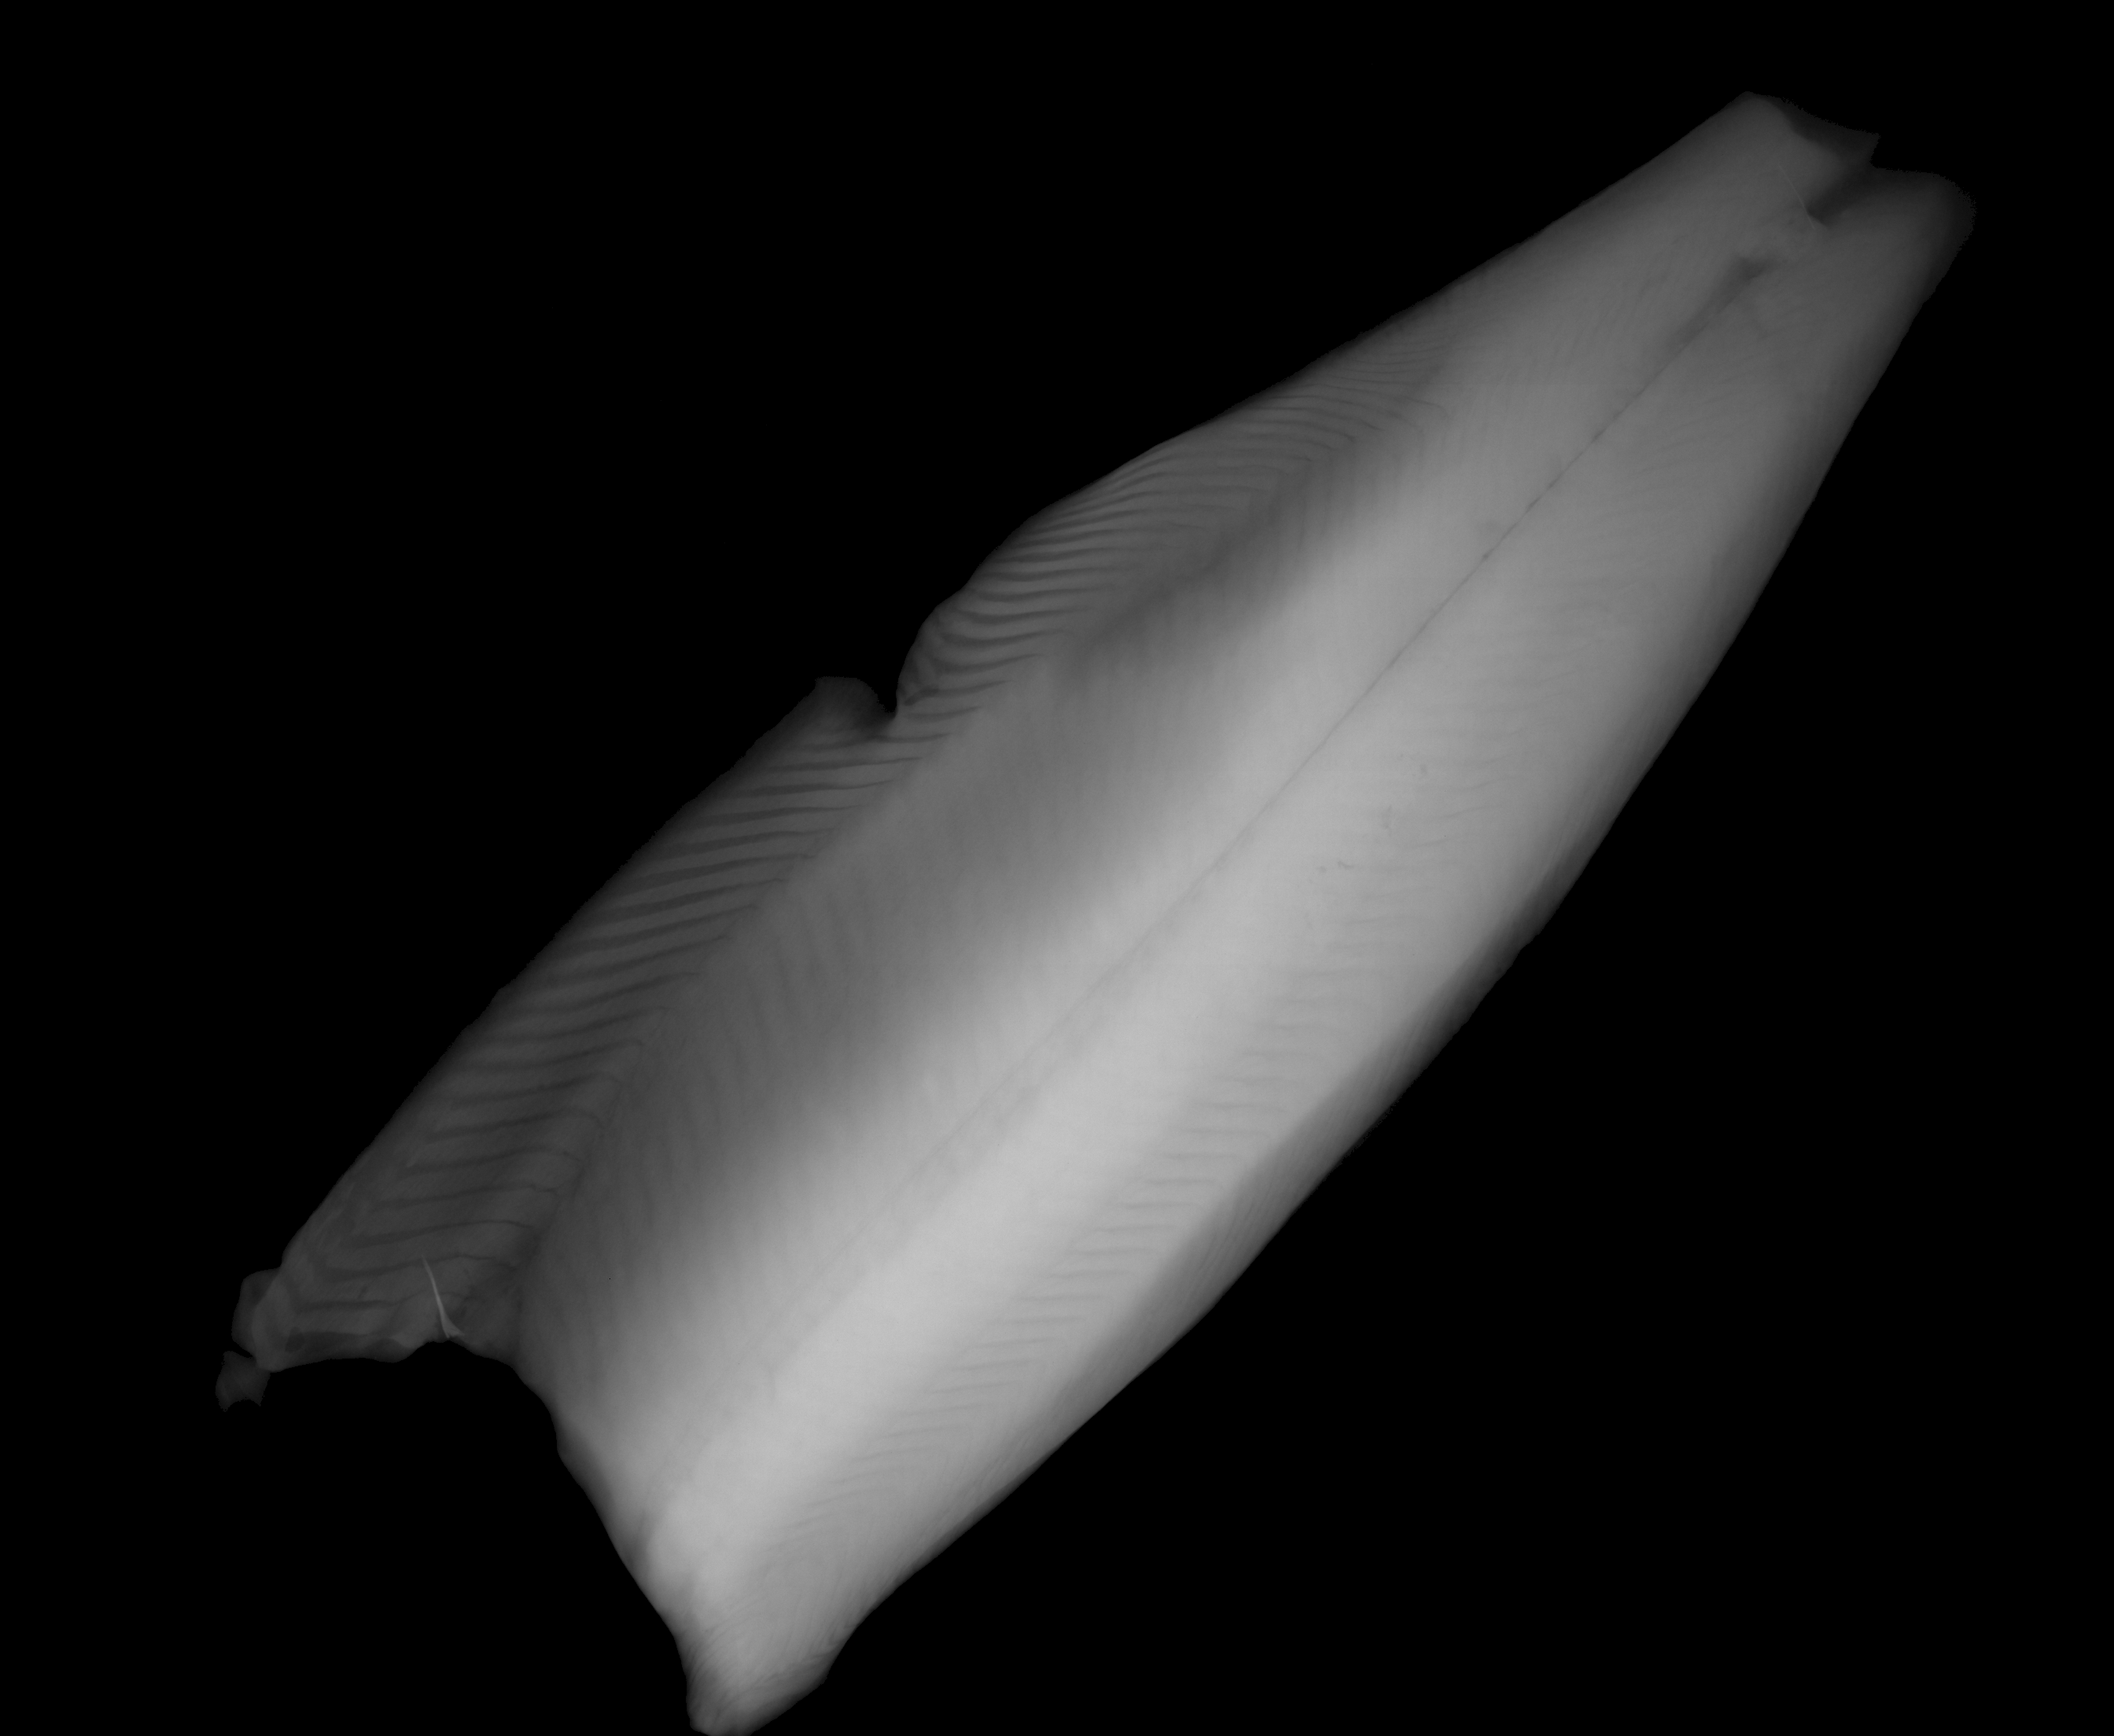

In [61]:
Image(filename='data/XNature/' + class_chosen.value[0] + '/' + picture_chosen.value[0])

There is only one type of knife, shuriken, key and gun. The different pictures are just different angles or side of them. On the contrary, it looks like there are several types of fruits (apple, limon and plums), wood and salmon. This can be one of the limits of our model since it won't be able to train on many differents type of weapons.

It is also notable that the photos seems to be in black and white.

# 2. Data preparation

In this section we will prepare the data in order to build the model. Since the data are only images, no preprocessing is needed before the model construction. Therefore, the only step presented in this section is the random split of training and validation dataset. 

Before the redaction of this notebook, one random image of every class has been removed and put in a directory "test". These data are going to be used to evaluate the model with totally new images. In this section, there are also some images found on the internet that will be presented later.

To do so, it has been decided to use a separation with directories. Indeed, this structure is going to be used in the next steps. The split ratio chosen is 80%.

In [62]:
# Split Train and validation data

all_files = glob.glob("data/XNature/*/*.png")

train_split = 0.8
validation_split = 1-train_split

n_images = len(all_files)
split = int(np.floor(validation_split * n_images))

indices = list(range(n_images))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]


In [63]:
# Training data 

for i in range(0, len(train_indices)):
    path = all_files[train_indices[i]]
    destination = path.split("/")
    a= shutil.copy(path, 
                   "data/training/" + destination[2])

In [64]:
# Validation data

for i in range(0, len(val_indices)):
    path = all_files[val_indices[i]]
    destination = path.split("/")
    a= shutil.copy(path, 
                   "data/validation/" + destination[2])

# 3. Construction of model

## Architecture of the model

The model is going to be a Convolutional Neural Network. It is generally known as the most efficient solution for classification of images. Several choices have been made:
- The input images are going to be 64x64 pixels, this choice was made in order to balance the quality of information and time of calculation
- 32 feature detectors (3x3) compose the two convolution layer
- The max pooling size is 2x2
- The last part of the CNN is going to be composed of a 128 neurons layer


In [70]:
# Initialising the CNN
classifier = Sequential()

# Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Max Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 8, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


## Image preprocessing

In order to ensure that we have enough data, several image data are going to be generated. For every image showed to the model (train or validation data), 3 other pictures will be shown too. These images will derivate from the original image, at every generation the original picture will have:
- 20% of chance to be sheared 
- 20% of chance to be zoomed
- 50% of chance to be flipped horizontally
- 50% of chance to be flipped vertically


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   vertical_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True, 
                                  vertical_flip = True)

training_set = train_datagen.flow_from_directory('data/training',
                                                 target_size = (64, 64),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('data/validation',
                                            target_size = (64, 64),
                                            batch_size = 4,
                                            class_mode = 'categorical')

In [82]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early]

classifier.fit_generator(training_set,
                         steps_per_epoch = len(train_indices),
                         epochs = 10,
                         validation_data = test_set,
                         validation_steps = len(val_indices),
                         callbacks = callbacks_list)

Epoch 1/10
2373/2373 [==============================] - 617s 260ms/step - loss: 0.0215 - accuracy: 0.9939 - val_loss: 7.1130e-04 - val_accuracy: 0.9920

Epoch 00001: val_loss improved from inf to 0.00071, saving model to model.hdf5
Epoch 2/10
2373/2373 [==============================] - 657s 277ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 4.3457e-04 - val_accuracy: 0.9962

Epoch 00002: val_loss improved from 0.00071 to 0.00043, saving model to model.hdf5
Epoch 3/10
2373/2373 [==============================] - 602s 254ms/step - loss: 0.0224 - accuracy: 0.9948 - val_loss: 2.4079e-05 - val_accuracy: 0.9979

Epoch 00003: val_loss improved from 0.00043 to 0.00002, saving model to model.hdf5
Epoch 4/10
2373/2373 [==============================] - 622s 262ms/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.0000e+00 - val_accuracy: 0.9975

Epoch 00004: val_loss improved from 0.00002 to 0.00000, saving model to model.hdf5
Epoch 5/10
2373/2373 [==============================] - 665s

The final accuracy is upper than 99% on the validation dataset which is really enormous. The final step is to evaluate the model deeper.

# 4. Model Evaluation

## Confusion Matrix & F1 score

We are going to calculate manually the predictions on the validation dataset and then calculate the confusion matrix and f1 score.

In [84]:
class_dictionnary = test_set.class_indices
print("The numbers given for each class is {}".format(class_dictionnary))

The numbers given for each class is {'Fruits': 0, 'Gun': 1, 'Key': 2, 'Knife': 3, 'Razor': 4, 'Salmon': 5, 'Shuriken': 6, 'Wood': 7}


In [91]:
y_true = []
y_pred = []

for tool in list_object:
    list_picture = glob.glob("data/validation/" + tool + "/*")
    answer = class_dictionnary[tool]
    for picture in list_picture:
            test_image = image.load_img(picture, target_size=(64,64))
            test_image = image.img_to_array(test_image)
            test_image = np.expand_dims(test_image, axis=0)
            result = classifier.predict(test_image)
            pred = int(np.where(result[0] == np.amax(result, axis=1))[0])
            y_true.append(int(answer))
            y_pred.append(int(pred))

In [99]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_pred)

print("The matrix of confusion of the model with the prediction of the all validation dataset is: \n\n{}".\
                                      format(matrix))

The matrix of confusion of the model with the prediction of the all validation dataset is: 

[[  7   0   0   2   0   0   0   1]
 [  0  45   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0]
 [  0   0   0 327   0   0   1   0]
 [  0   0   0   0  27   0   0   0]
 [  0   0   0   0   0  37   0   0]
 [  0   0   0   0   0   0 114   0]
 [  0   0   0   0   0   0   0  27]]


In [106]:
from sklearn.metrics import f1_score

score = f1_score(y_true, y_pred, average='macro') 

print("The f1 score of our model with the prediction of the all validation dataset is {0:.2f} %".\
                                      format(score*100))

The f1 score of our model with the prediction of the all validation dataset is 97.46 %


The model has a perfect accuracy with every type of object images except with:
- knife: 1 error for 328 predictions (thought it was a shuriken)
- fruits: 3 errors for 10 predictions (thought 2 times it was a knife and one time that it was wood)

The F1 score is really high too with a score higher than 97%.

## Predictions on new images 

Now that it has been proven that the model has good performances with validation data, the last interesting test that can be done is to predict images that it never saw. To do this, one image of every object has been removed before the notebook has been ran.

In [107]:
test_images = glob.glob("data/test/*.png")

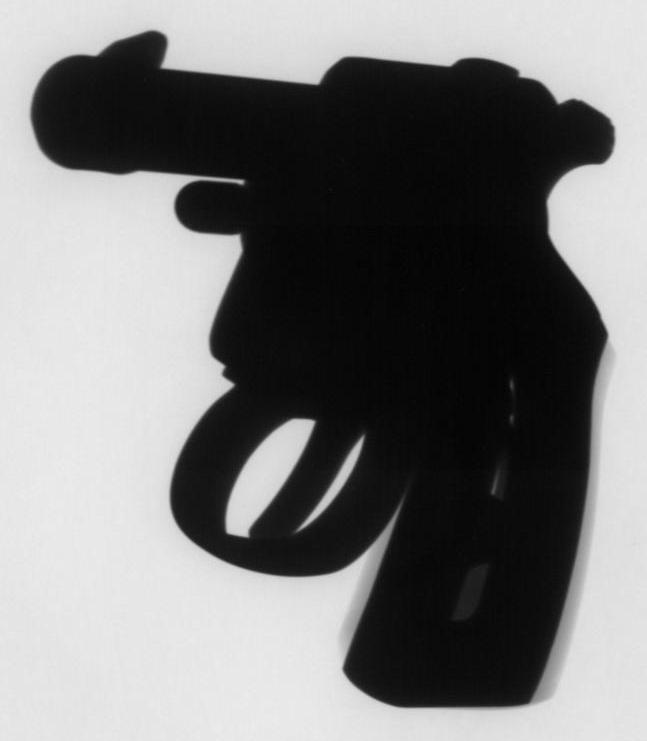

In [109]:
Image(filename=test_images[0])

It is a gun, now let's see the prediction of the model.

In [118]:
def is_true(answer, image_chosen):
    test_image = image.load_img(image_chosen, target_size=(64,64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = classifier.predict(test_image)
    pred = int(np.where(result[0] == np.amax(result, axis=1))[0])
    answer = class_dictionnary[answer]
    if answer - pred == 0:
        print("The model predicted good !")
    else:
        print("The model predicted poorly, he gave {} as an answer".format(pred))

In [120]:
is_true("Gun", test_images[0])

The model predicted good !


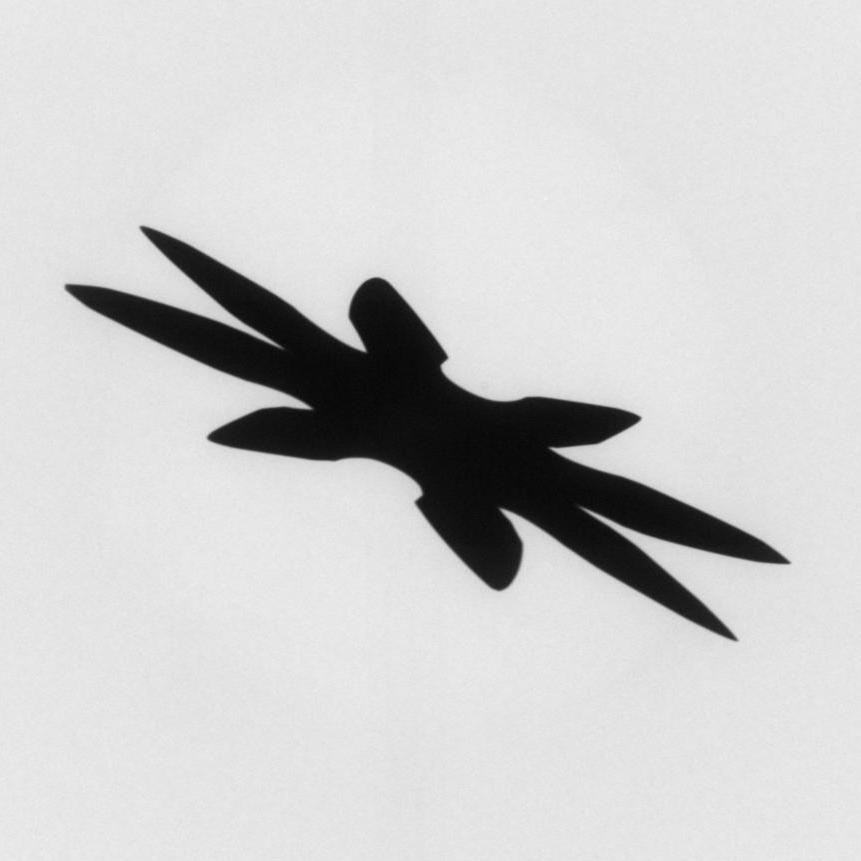

In [121]:
Image(filename=test_images[1])

In [122]:
is_true("Shuriken", test_images[1])

The model predicted good !


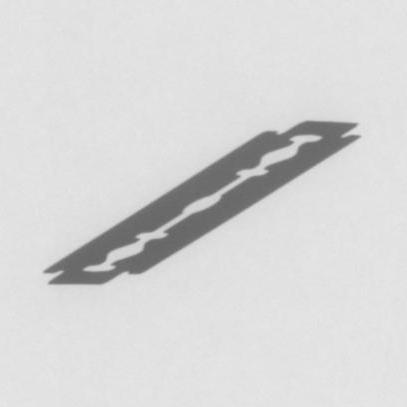

In [123]:
Image(filename=test_images[2])

In [124]:
is_true("Razor", test_images[2])

The model predicted good !


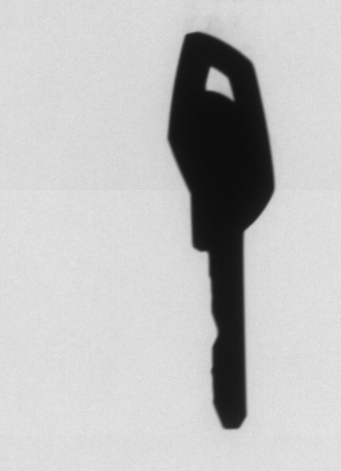

In [125]:
Image(filename=test_images[3])

In [126]:
is_true("Key", test_images[3])

The model predicted good !


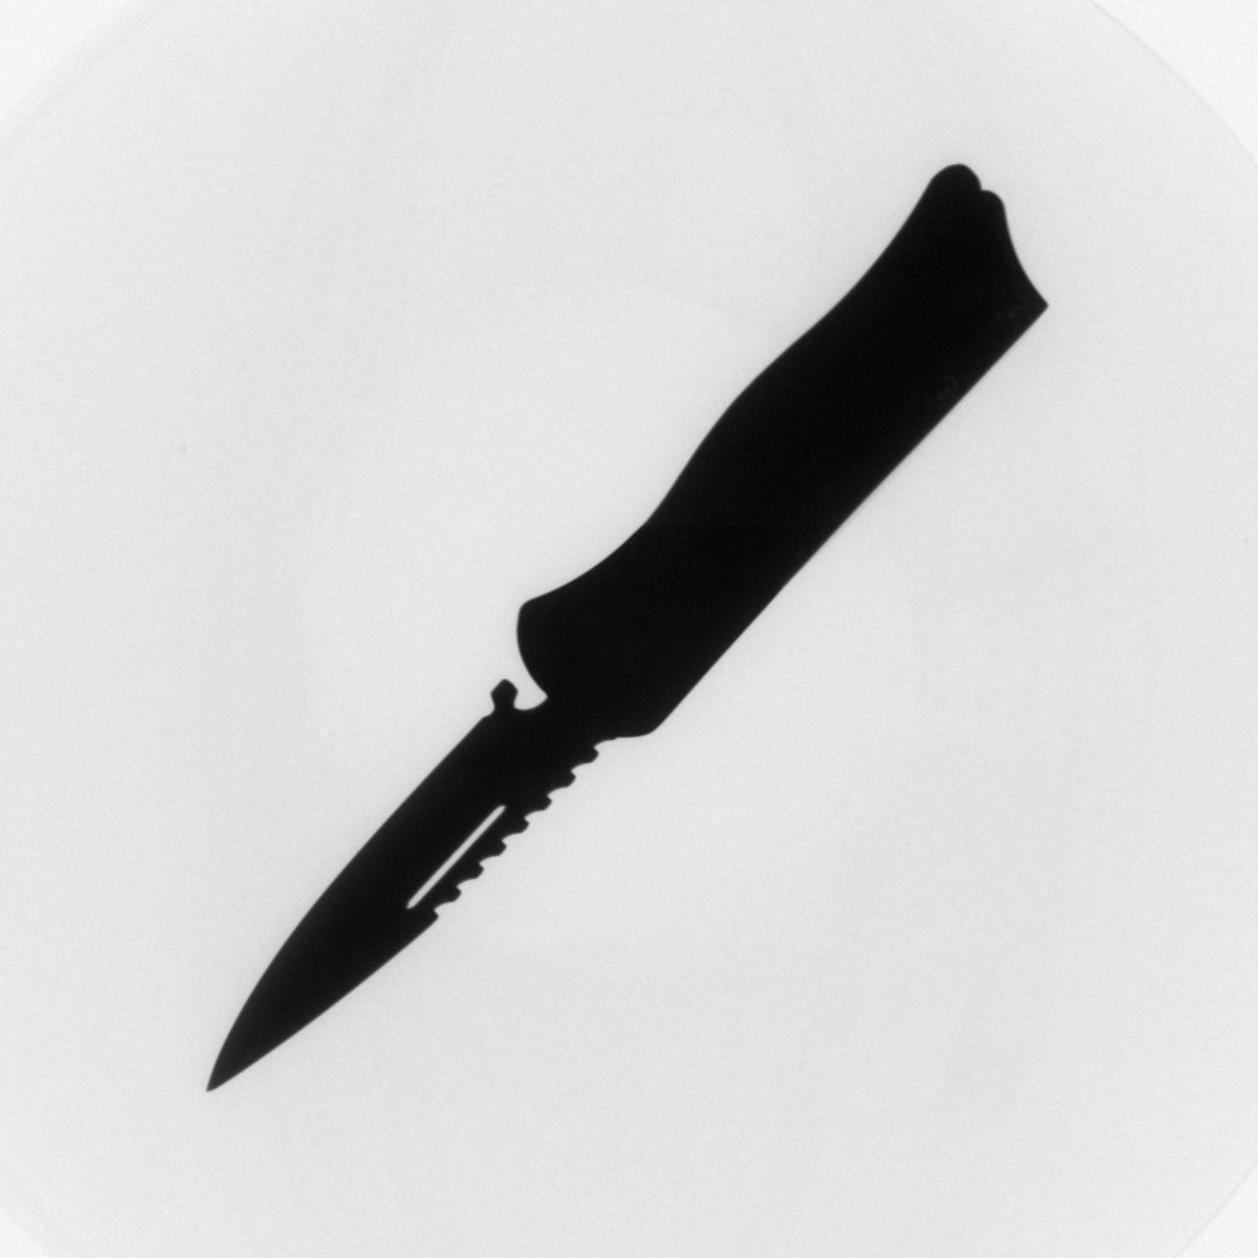

In [127]:
Image(filename=test_images[4])

In [128]:
is_true("Knife", test_images[4])

The model predicted good !


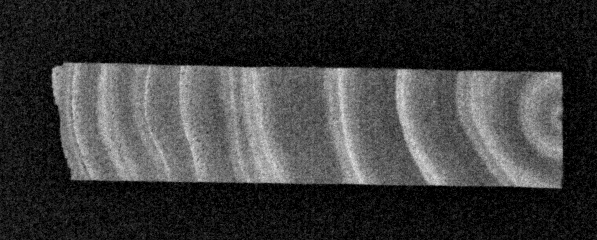

In [129]:
Image(filename=test_images[5])

In [130]:
is_true("Wood", test_images[5])

The model predicted good !


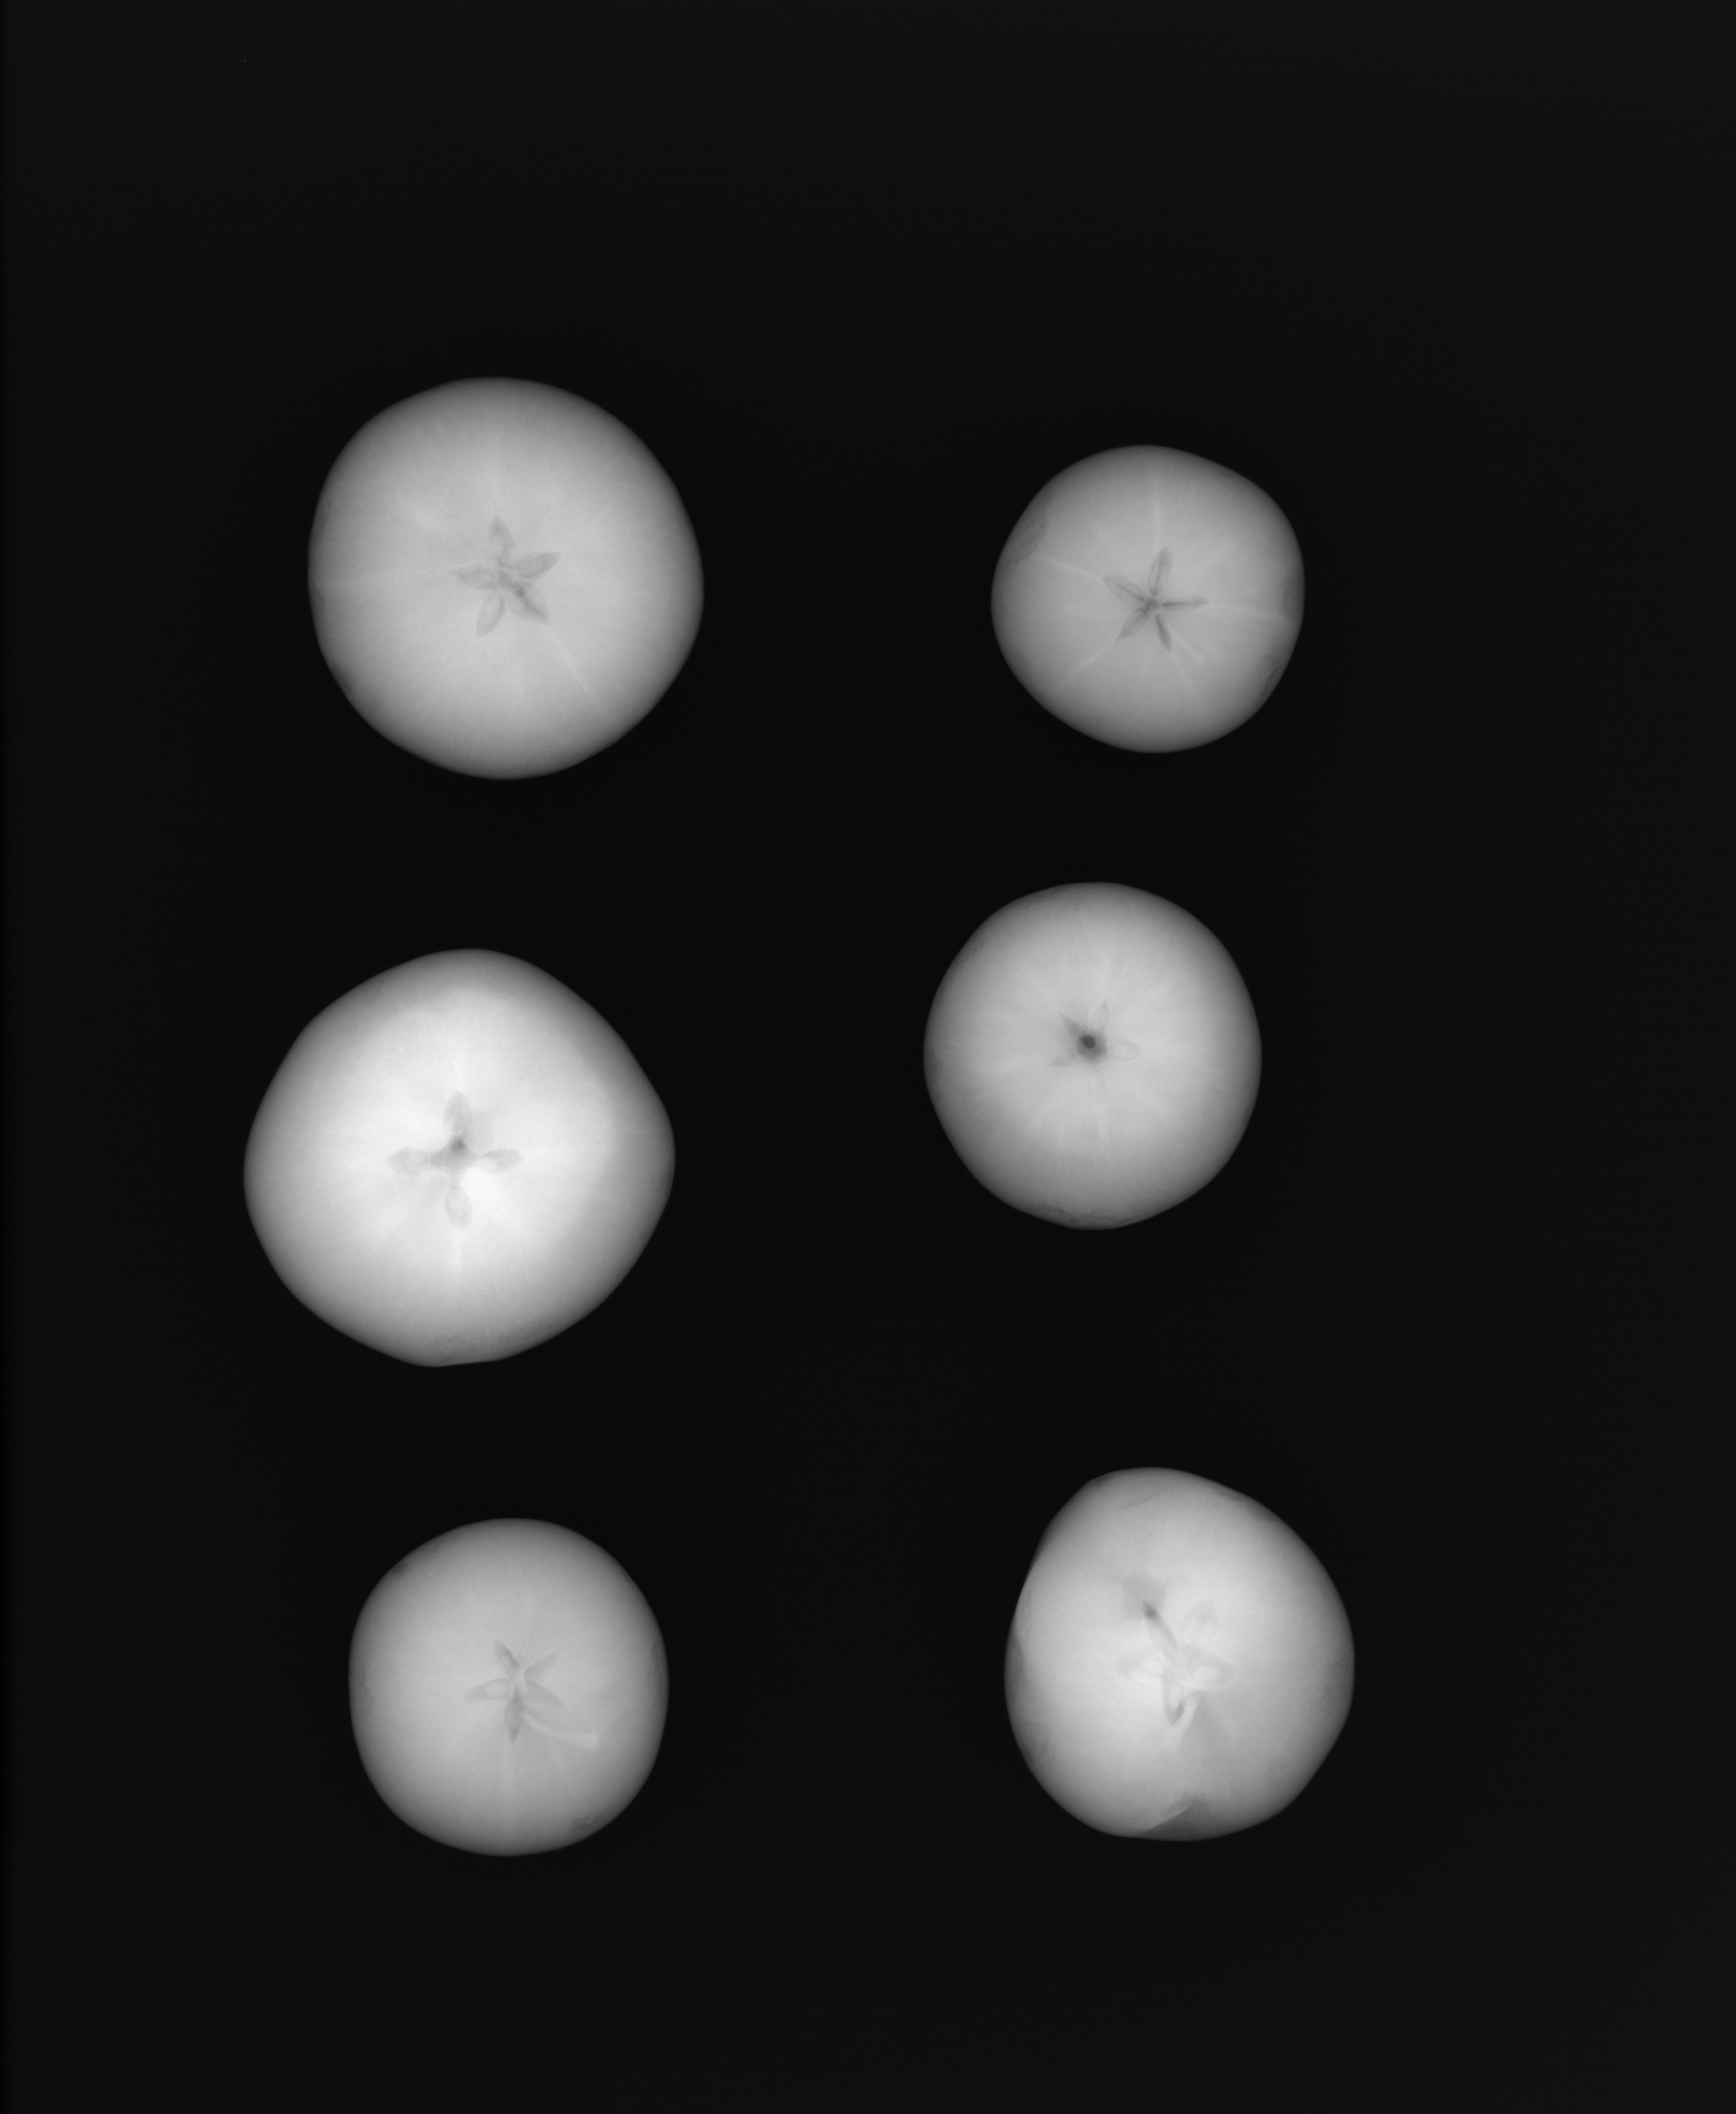

In [131]:
Image(filename=test_images[6])

In [133]:
is_true("Fruits", test_images[6])

The model predicted good !


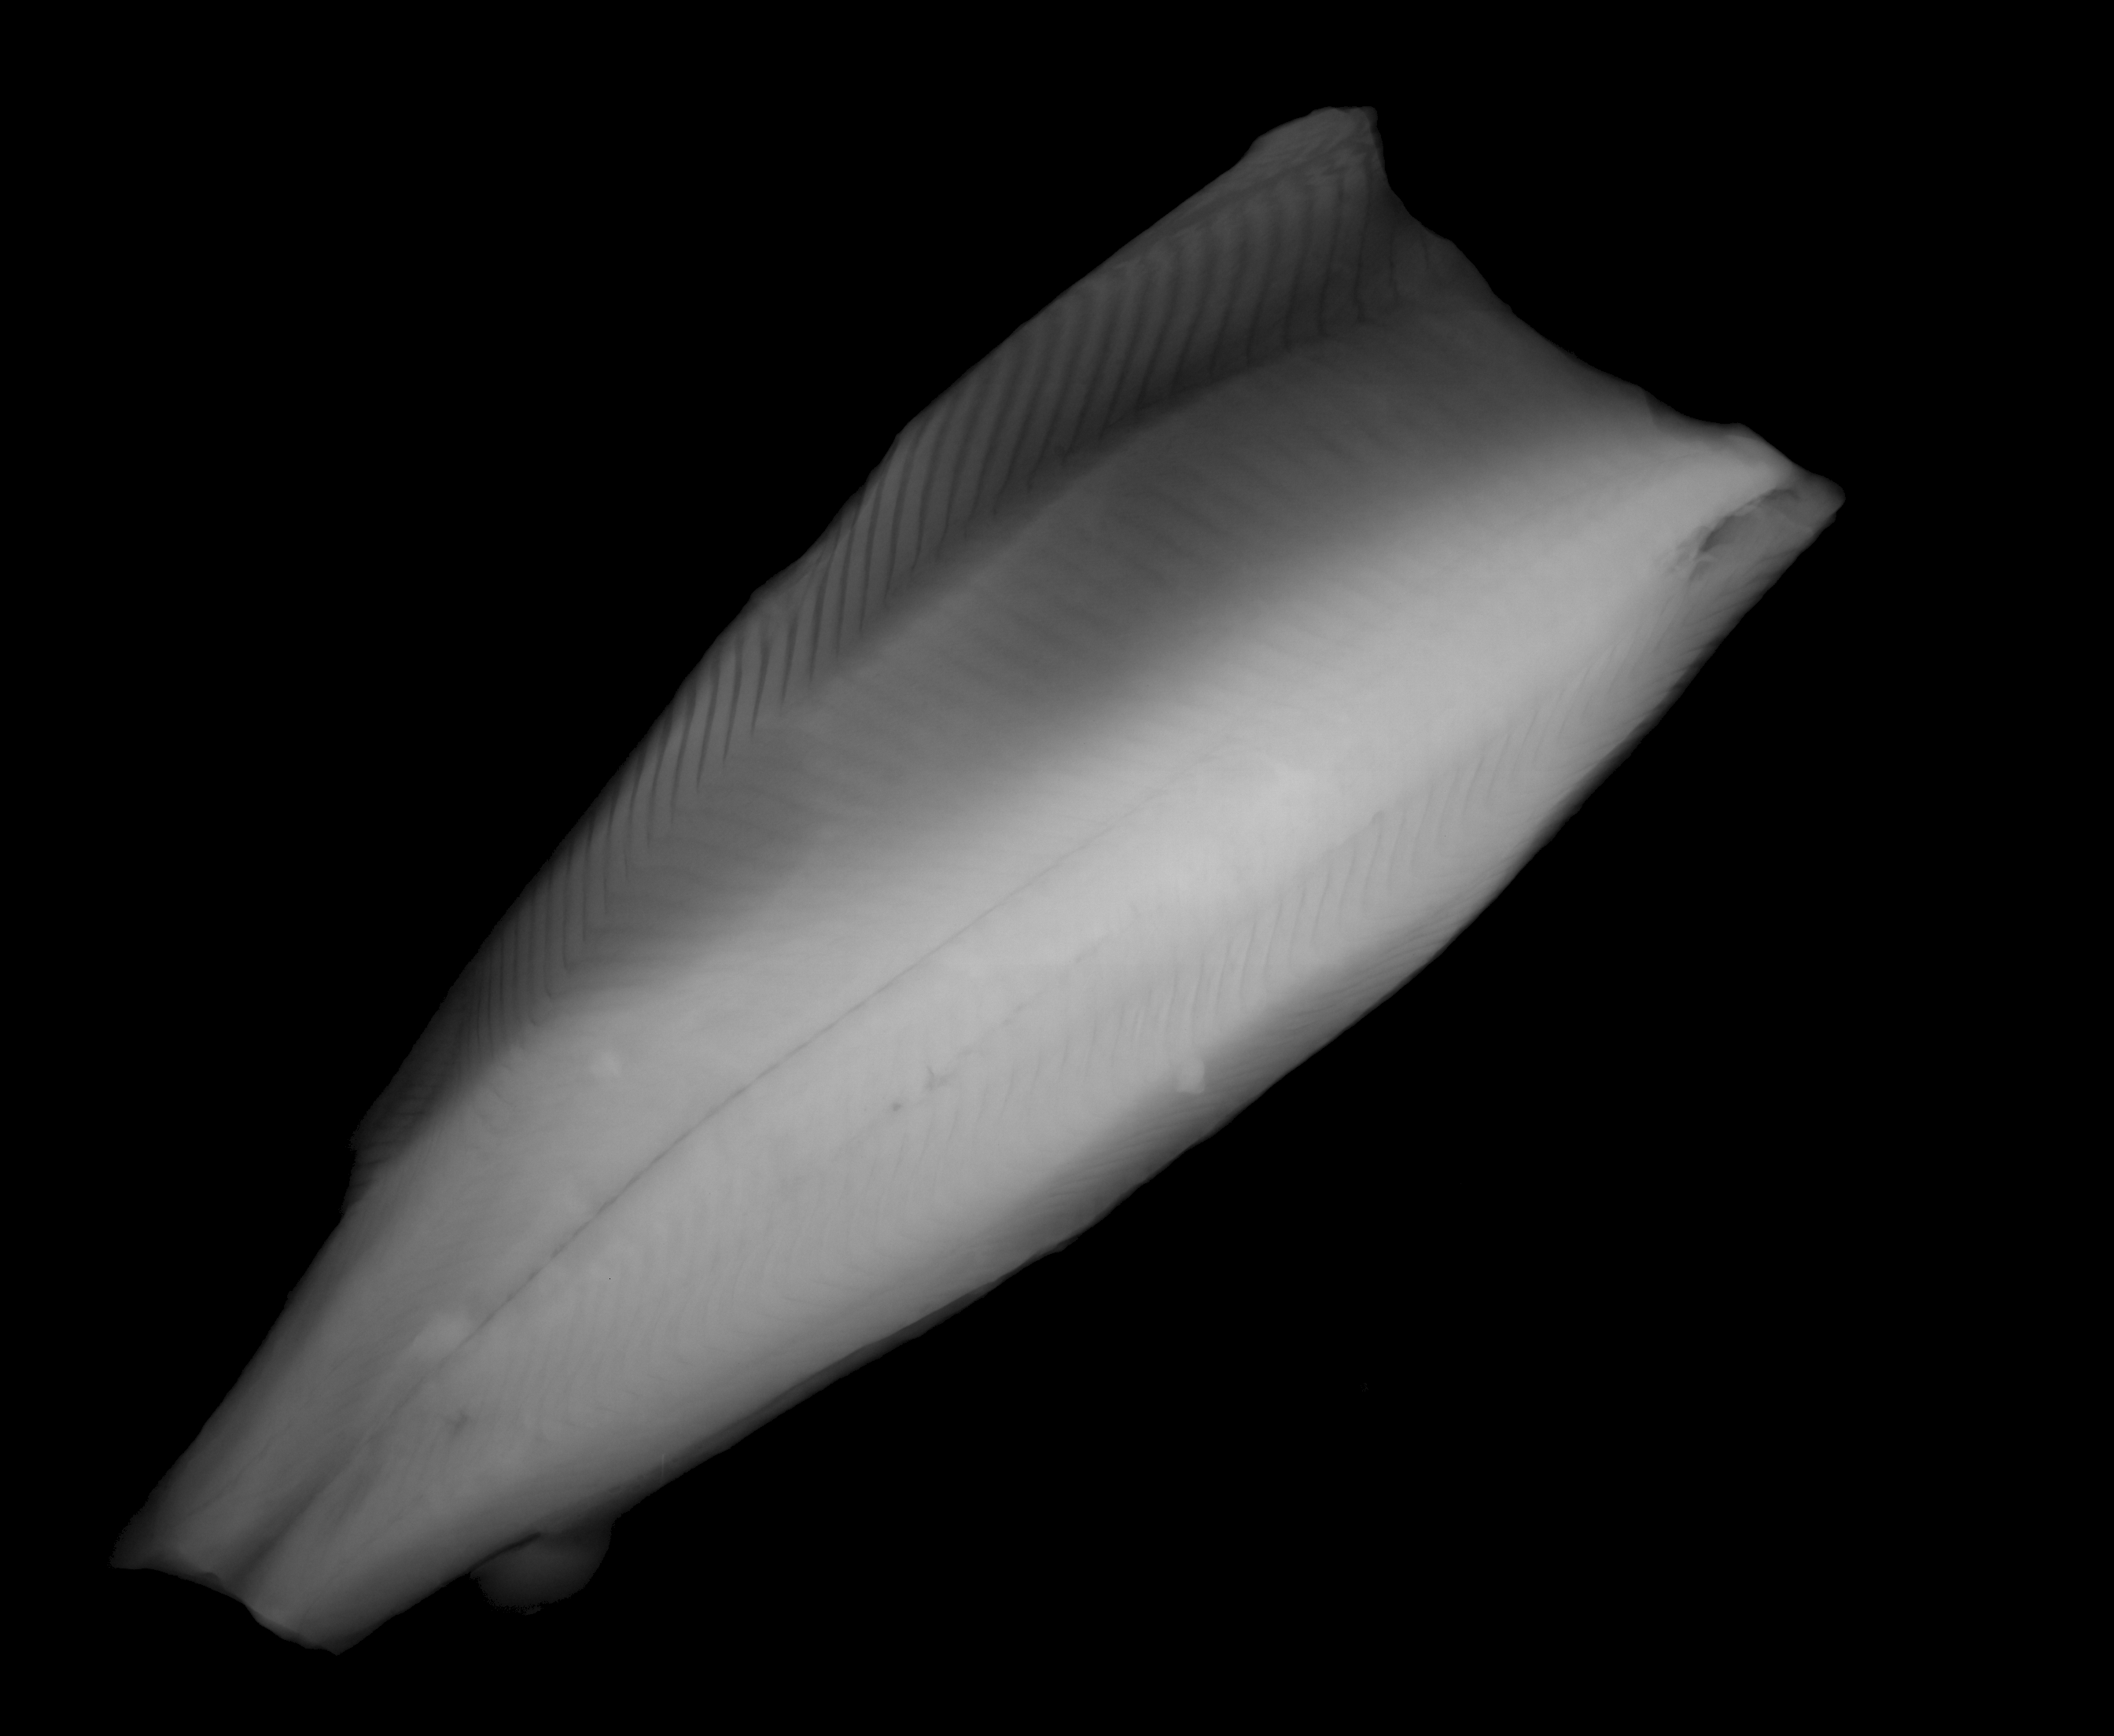

In [136]:
Image(filename=test_images[8])

In [138]:
is_true("Salmon", test_images[8])

The model predicted good !


The model has great results, even with data that it never saw.

## Prediction of images out of initial dataset

Some pictures of objects have been found on the internet and can be used to see if the model manages to recognize them.

In [139]:
test_internet = glob.glob("data/test/internet/*")

In [140]:
test_internet

['data/test/internet/apple.jpg',
 'data/test/internet/gun.jpeg',
 'data/test/internet/knife.jpg',
 'data/test/internet/shuriken.jpg',
 'data/test/internet/wood.png']

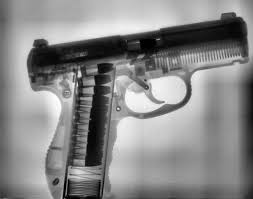

In [143]:
Image(filename=test_internet[1])

In [145]:
is_true("Gun", test_internet[1])

The model predicted good !


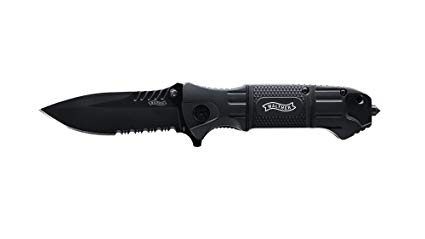

In [146]:
Image(filename=test_internet[2])

In [147]:
is_true("Knife", test_internet[2])

The model predicted good !


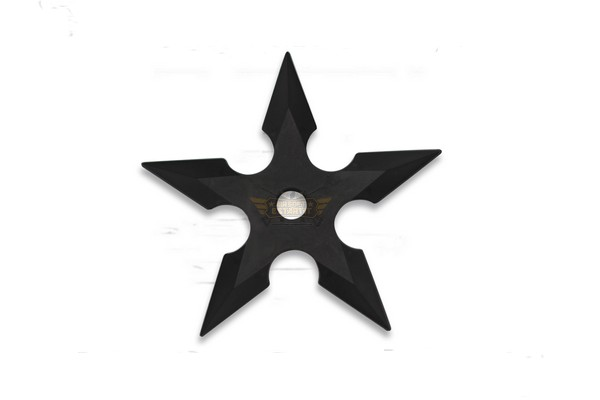

In [148]:
Image(filename=test_internet[3])

In [149]:
is_true("Shuriken", test_internet[3])

The model predicted good !


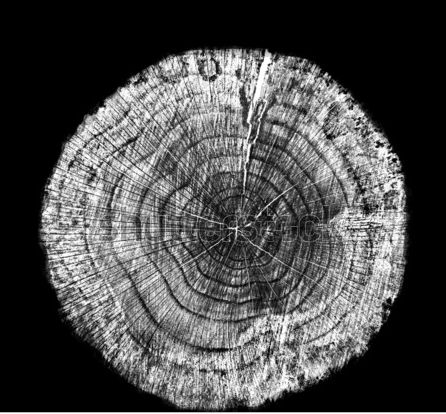

In [150]:
Image(filename=test_internet[4])

In [151]:
is_true("Wood", test_internet[4])

The model predicted poorly, he gave 0 as an answer


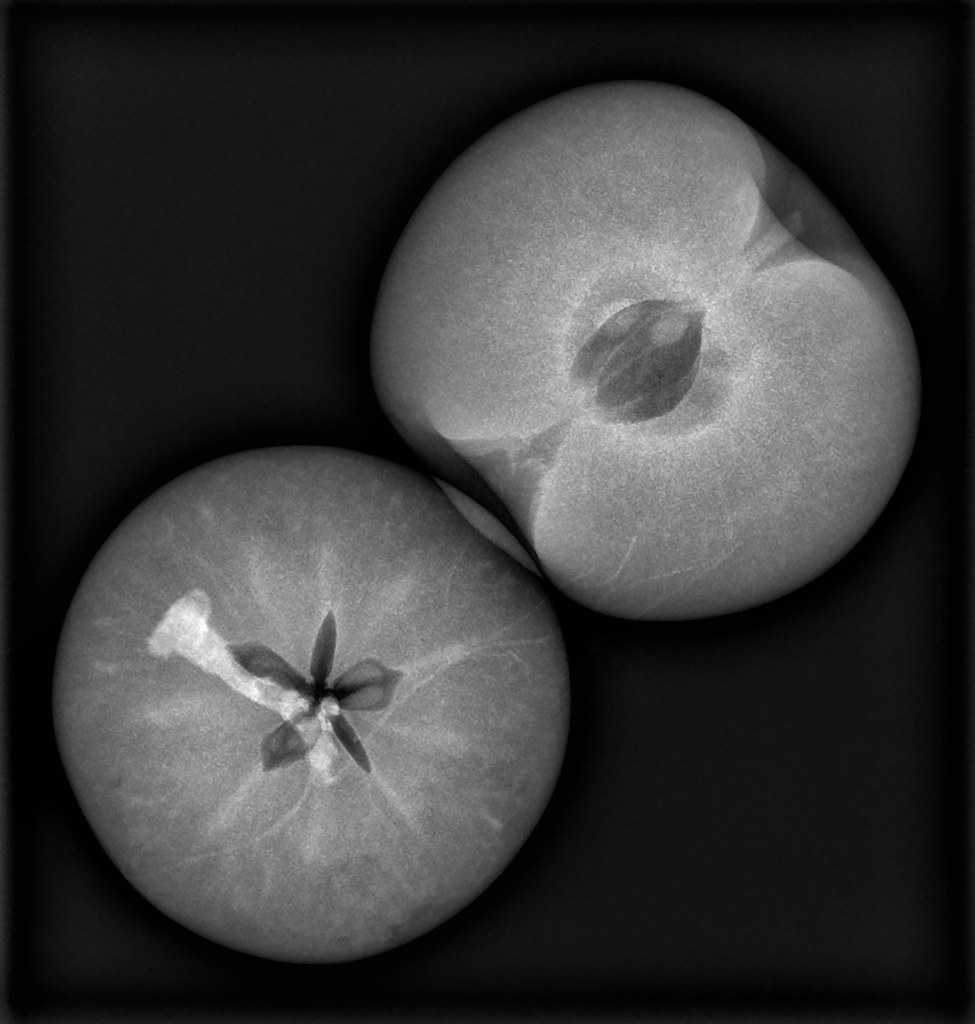

In [152]:
Image(filename=test_internet[0])

In [155]:
is_true("Fruits", test_internet[0])

The model predicted poorly, he gave 5 as an answer


The model manages to recognise the knife, gun and shuriken but not the apple and wood. To explain these errors we can say that the model did not train with any picture of entire piece of wood. 

## Conclusion 

The model that has been developed is really good to evaluate the pictures given by the dataset. It seems also very good to identify the patterns of weapons such as guns, shuriken and knife. In order to try to improve it and to ameliorate its generalization, it would be interesting to add more pictures and specificaly more objects (there is only one type of gun and one type of key for example).